In [1]:
import sys
import pandas as pd
sys.path.append('../component')
from utils import *
from class_ARIMA_model import *
import os
os.getcwd()

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/ubuntu/Capstone_Group_1/code/main_code'

In [19]:
df = pd.read_csv('../data/weather.csv', parse_dates=['date'])
# plot_time_series(df)
item_list = df.columns[1]
# plt_rolling_mean_var(df, item_list)
new_ts = differencing(df, 1, item_list)
df['1st_diff'] = new_ts
# plt_rolling_mean_var(df, df.columns[2])
# ADF_test(df.iloc[:, 2])
# kpss_test(df.iloc[:, 2])
# GPAC_table(df.iloc[:, 2], J=12, K=12)

In [20]:
df_train, df_temp = train_test_split(df, test_size=0.3, shuffle=False)
df_test, df_val = train_test_split(df_temp, test_size=0.5, shuffle=False)

In [21]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)
data = df_train['1st_diff'].values.reshape(-1, 1)

In [22]:
data.shape

(73684, 1)

In [23]:
# Define the parameter grid
param_grid = {'AR_order': range(1, 11)}  # Testing lags 1 to 10

from sklearn.metrics import mean_squared_error
def neg_mean_squared_error(estimator, X, y=None):
    y_pred = estimator.predict(X)
    return -mean_squared_error(X.ravel(), y_pred)

model = ARIMA_model()
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=tscv, 
                           scoring=neg_mean_squared_error,
                           verbose=1)

# Perform the grid search
grid_search.fit(data)

# Print the results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Lowest MSE: {-grid_search.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [24]:
# Fit the final model with the best order
# best_order = grid_search.best_params_['AR_order']
best_order = 1
final_model = ARIMA_model(AR_order=best_order)
final_model.fit(data)

in_sample_pred = final_model.predict(data)
print("\nIn-sample prediction (last 5 values):")
print(in_sample_pred[-5:])


In-sample prediction (last 5 values):
[-0.0880327   0.09885436  0.06711882 -0.01927236  0.0583034 ]


In [25]:
# Out-of-sample forecast
forecast_steps = df_test.shape[0]  # Adjust as needed
forecast = final_model.forecast(forecast_steps)

In [26]:
rev_forecast = []
value = df_train.iloc[-1, 0]
for i in range(0, len(forecast)):
    value += forecast[i]
    rev_forecast.append(value)

In [51]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date', inplace=True)

In [55]:
MSE(df_test.iloc[:, 0], rev_forecast)

66.05148722525206

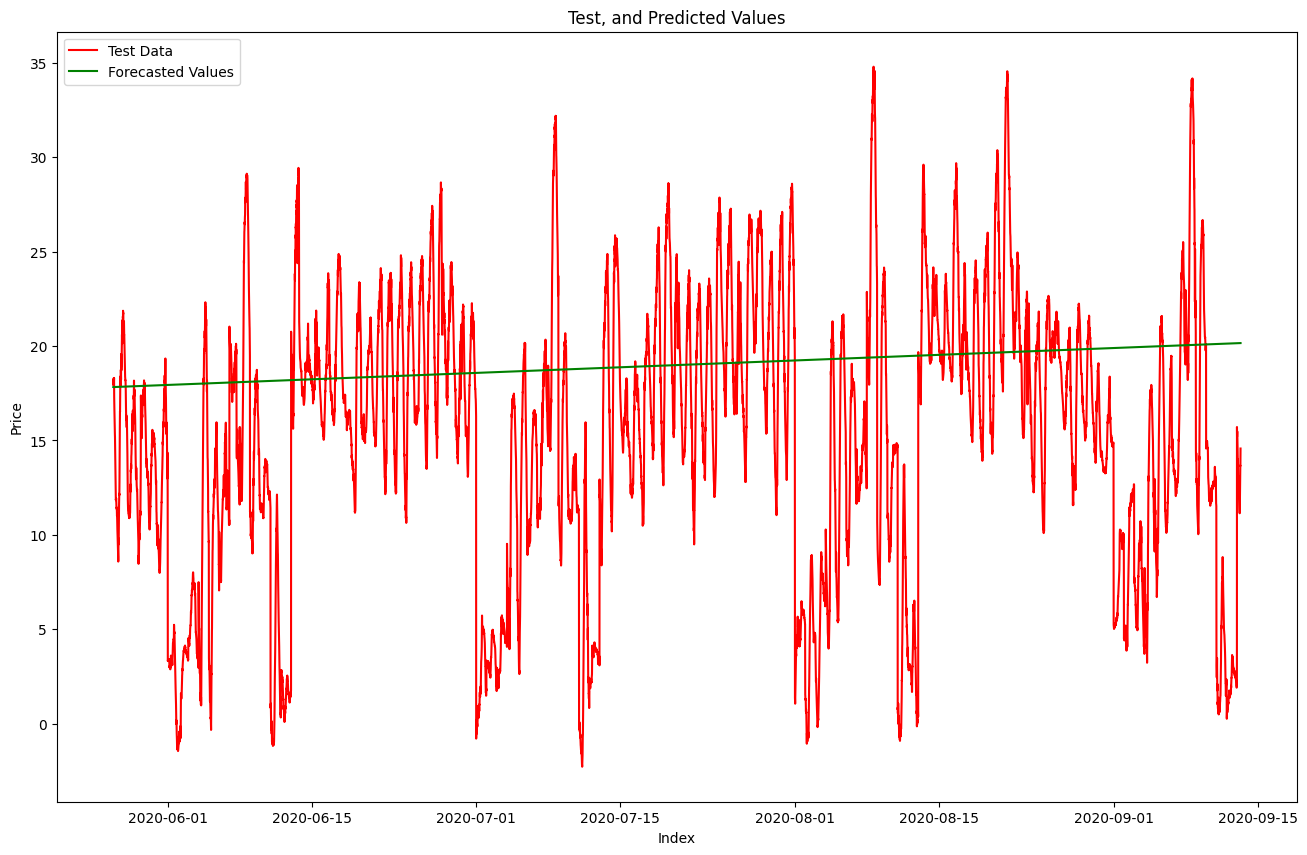

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))

plt.plot(df_test.index, df_test.iloc[:, 0], label='Test Data', color='red')
plt.plot(df_test.index, rev_forecast, label='Forecasted Values', color='green')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.title('Test, and Predicted Values')
plt.show()

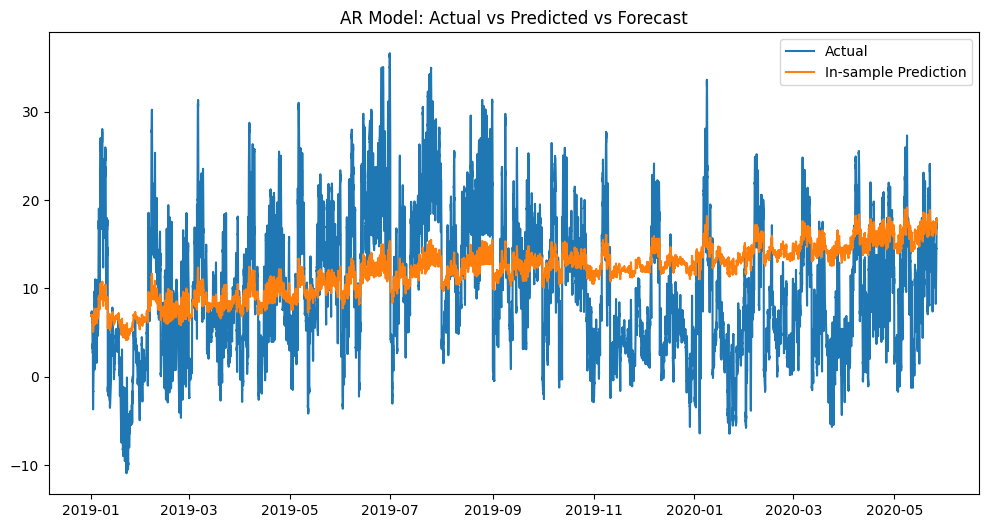

In [62]:
# Optional: Plot results
rev_pred = []
value = df_train.iloc[0, 0]
for i in range(0, len(in_sample_pred)):
    value += in_sample_pred[i]
    rev_pred.append(value)
    
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train.iloc[:, 0], label='Actual')
plt.plot(df_train.index, rev_pred, label='In-sample Prediction')
plt.legend()
plt.title('AR Model: Actual vs Predicted vs Forecast')
plt.show()

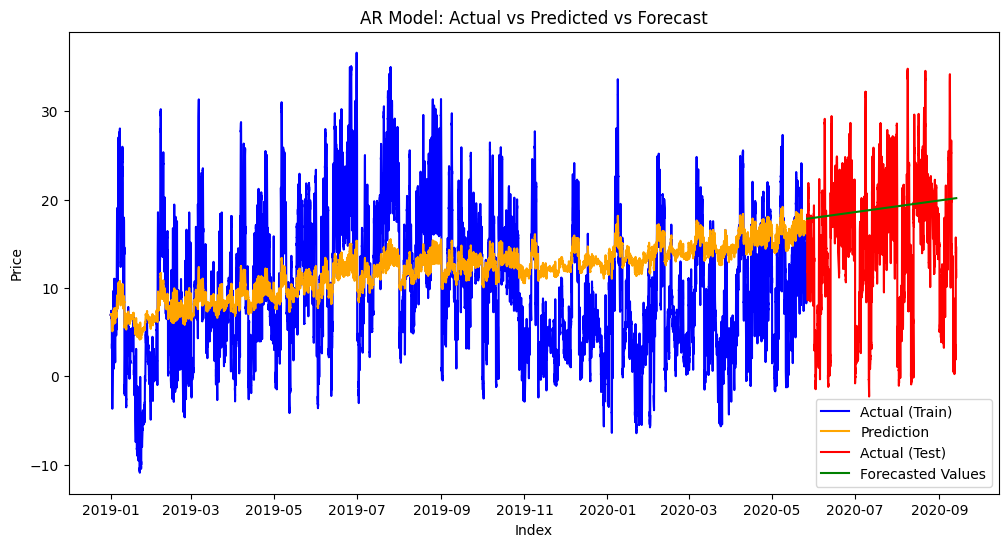

In [64]:
import matplotlib.pyplot as plt

# Create a single figure with a combined plot
plt.figure(figsize=(12, 6))

# Plot actual vs in-sample prediction (training data)
plt.plot(df_train.index, df_train.iloc[:, 0], label='Actual (Train)', color='blue')
plt.plot(df_train.index, rev_pred, label='Prediction', color='orange')

# Plot test data and forecast (out-of-sample prediction)
plt.plot(df_test.index, df_test.iloc[:, 0], label='Actual (Test)', color='red')
plt.plot(df_test.index, rev_forecast, label='Forecasted Values', color='green')

# Set labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('AR Model: Actual vs Predicted vs Forecast')
plt.legend()

# Show the combined plot
plt.show()

In [2]:
def objective(trial, data, n_splits=5):
    ar_order = trial.suggest_int('AR_order', 1, 20)  # Adjust the range as needed
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []
    
    for train_index, test_index in tscv.split(data):
        train, test = data[train_index], data[test_index]
        model = ARIMA_model(AR_order=ar_order)
        model.fit(train)
        predictions = model.predict(test)
        mse = mean_squared_error(test, predictions)
        mse_scores.append(mse)
    
    return np.mean(mse_scores)

In [4]:
df = pd.read_csv('../data/weather.csv', parse_dates=['date'])
item_list = df.columns[1]
new_ts = differencing(df, 1, item_list)
df['1st_diff'] = new_ts
df_train, df_temp = train_test_split(df, test_size=0.3, shuffle=False)
df_test, df_val = train_test_split(df_temp, test_size=0.5, shuffle=False)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)
data = df_train['1st_diff'].values.reshape(-1, 1)

In [5]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, data), n_trials=5)  # Adjust n_trials as needed

# Print the best parameters and score
print(f"Best parameters: {study.best_params}")
print(f"Best MSE: {study.best_value}")

[I 2024-10-14 00:43:18,388] A new study created in memory with name: no-name-e8534d21-4e06-4d80-b556-87138703f584
[I 2024-10-14 00:44:52,858] Trial 0 finished with value: 0.2174480898447583 and parameters: {'AR_order': 7}. Best is trial 0 with value: 0.2174480898447583.
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-10-14 00:47:45,058] Trial 1 finished with value: 0.21799116537881486 and parameters: {'AR_order': 8}. Best is trial 0 with value: 0.2174480898447583.
[I 2024-10-14 00:49:50,884] Trial 2 finished with value: 0.21852964649518586 and parameters: {'AR_order': 9}.

KeyboardInterrupt: 

In [13]:
# Fit the final model with the best order
# best_ar_order = study.best_params['AR_order']
best_ar_order = 8
final_model_2 = ARIMA_model(AR_order=best_ar_order, MA_order=0, inte_order=0)
final_model_2.fit(data)

# In-sample prediction
in_sample_pred = final_model_2.predict(data)
print("\nIn-sample prediction (last 5 values):")
print(in_sample_pred[-5:])


In-sample prediction (last 5 values):
[-0.04065772  0.09511641  0.05648006  0.04824186  0.09820863]

Forecast for the next 10 steps:
[0.02723164 0.04135572 0.03126527 0.05046908 0.03431676 0.01537338
 0.02058448 0.00768099 0.01099324 0.01064825]


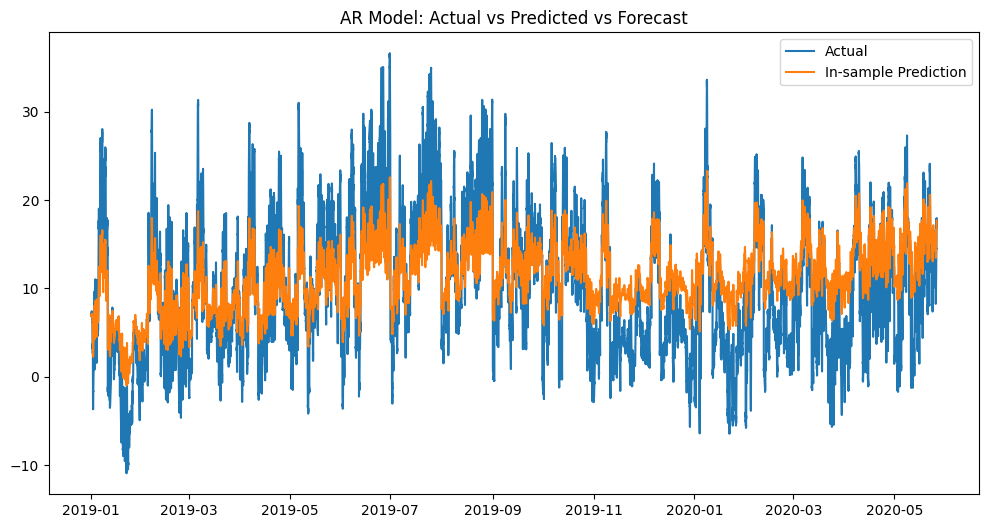

In [14]:
rev_pred = []
value = df_train.iloc[0, 0]
for i in range(0, len(in_sample_pred)):
    value += in_sample_pred[i]
    rev_pred.append(value)
    
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train.iloc[:, 0], label='Actual')
plt.plot(df_train.index, rev_pred, label='In-sample Prediction')
plt.legend()
plt.title('AR Model: Actual vs Predicted vs Forecast')
plt.show()

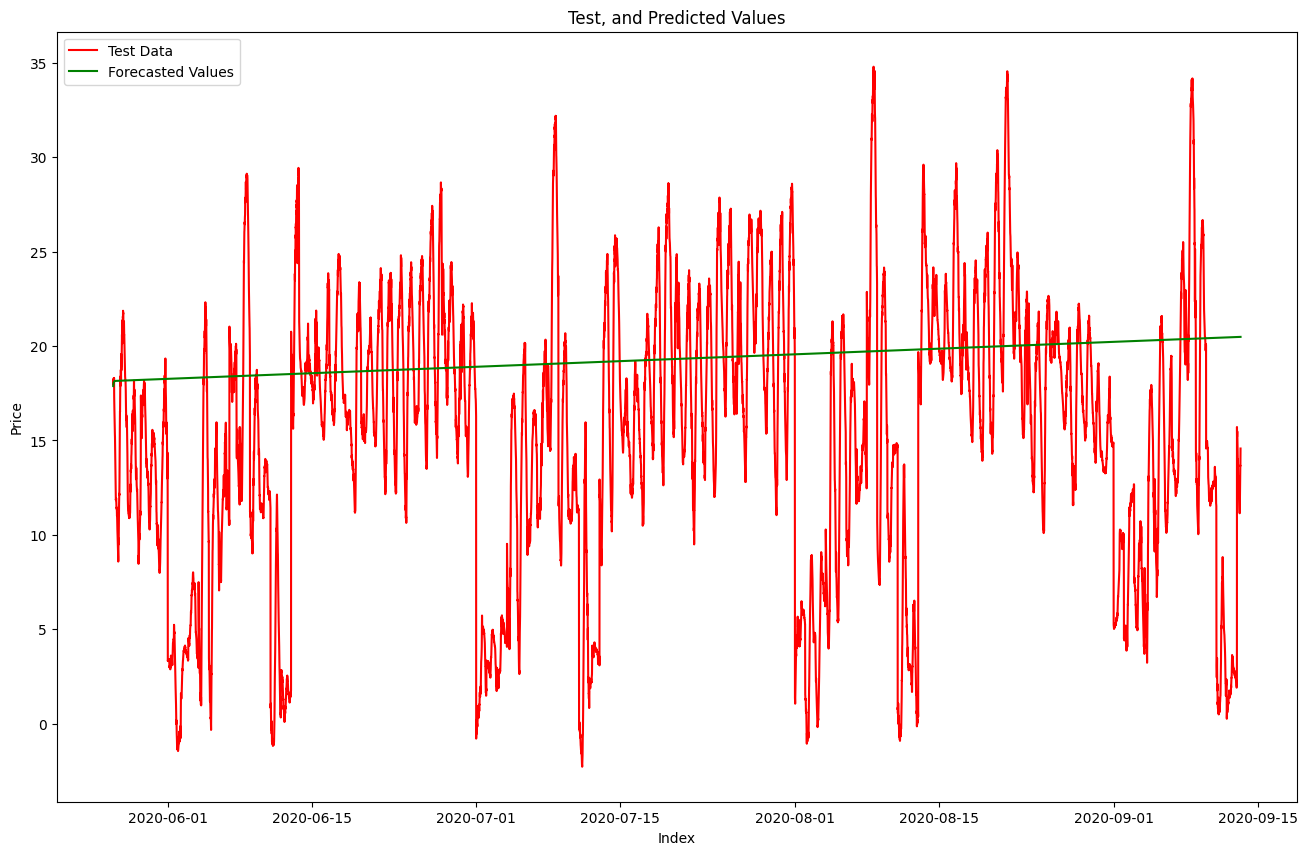

In [16]:
forecast_steps = df_test.shape[0]  # Adjust as needed
forecast = final_model_2.forecast(forecast_steps)

rev_forecast_2 = []
value = df_train.iloc[-1, 0]
for i in range(0, len(forecast)):
    value += forecast[i]
    rev_forecast_2.append(value)

MSE(df_test.iloc[:, 0], rev_forecast_2)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))

plt.plot(df_test.index, df_test.iloc[:, 0], label='Test Data', color='red')
plt.plot(df_test.index, rev_forecast_2, label='Forecasted Values', color='green')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.title('Test, and Predicted Values')
plt.show()

In [ ]:
# Plot the optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study)
plt.show()

# Plot the parameter importances
plt.figure(figsize=(10, 6))
optuna.visualization.plot_param_importances(study)
plt.show()